In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np

> if machine learning is simply trying to find functions, lets look at a really simple quadratic function $3x^2 + 2x + 1$

In [4]:
def plot_function(f, title=None, x=None, ylim=None):
    if x is None:
        x = np.linspace(-2, 2, 20)

    y = f(x)
    plt.plot(x, y)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)

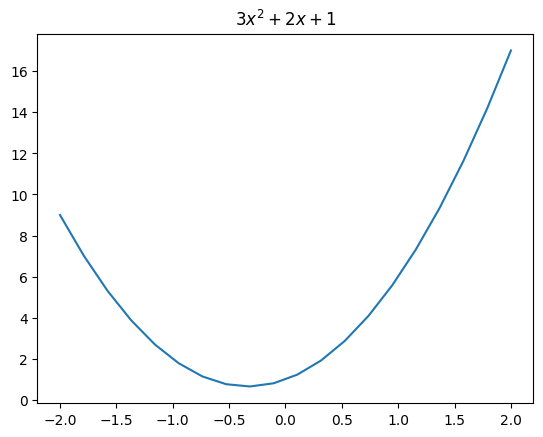

In [5]:
def f(x):
    return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

> lets build the general form of a quadratratic function $ax^2 + bx + c$, and create the `mk_quad` function that would easily create this function for us for an `a`, `b` and `c`

In [6]:
def quad(a,b,c, x):
    return a*x**2 + b*x + c

quad(3,2,1, 1.5)

10.75

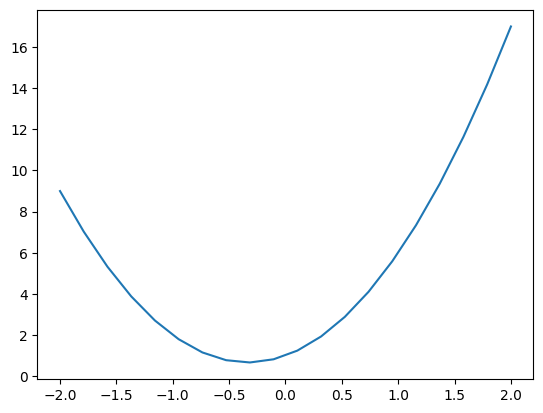

In [7]:
from functools import partial
def mk_quad(a,b,c):
    return partial(quad, a,b,c)

f = mk_quad(3, 2, 1)
plot_function(f)

> to make our learning example more realistic, lets add some noise to the data, because in the real world we dont get perfect data 

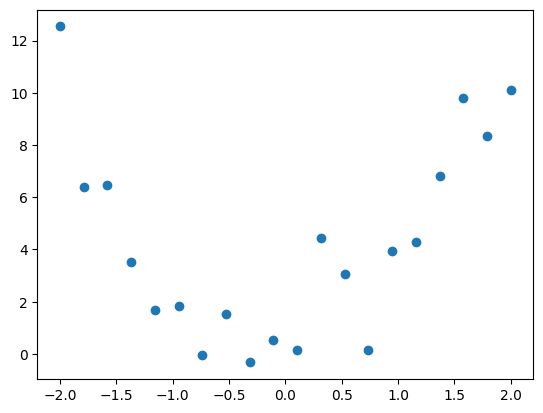

In [8]:
from numpy.random import normal, seed, uniform
np.random.seed(42)
def noise(x, scale):
    return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add):
    return x * (1+noise(x, mult)) + noise(x, add)

x = torch.linspace(-2, 2, 20)[:, None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

> lets make an interactive plot that will show us how well we fit the data for any `a`, `b`, `c` parameter combination

In [9]:
from ipywidgets import interact

@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    f = mk_quad(a, b, c)
    plot_function(f, ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

> To make this more rigorous, instead of judging with our eyes when the fit is good, lets use **Mean Square Error** or $MSE$ as the metric to judge how good is the fit

In [10]:
def mse(y, y_pred):
    return ((y-y_pred)**2).mean()

@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    f = mk_quad(a, b, c)
    loss = mse(y, f(x))
    plot_function(mk_quad(a,b,c), ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

> lets simplify even more by creating a function that given the parameters, just returns the loss

In [11]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(y, f(x))

quad_mse([1.5, 1.5, 1.5])

tensor(5.8336, dtype=torch.float64)

<img src="https://th.bing.com/th/id/R.5b85bd8d6ffd635d89b0f1c169021340?rik=Lqb1wMQz6DcFnQ&pid=ImgRaw&r=0" alt="drawing" width="800"/>
<img src="https://machinelearningknowledge.ai/wp-content/uploads/2021/04/typetensors-2048x1336.jpeg" alt="drawing" width="1000"/>



> now lets start with some initial guess of the a/b/c parameters

In [12]:
# rank 1 tensor
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

> compute the gradient, which would tell us how to change a/b/c instead of guessing

In [13]:
loss = quad_mse(abc)
print(loss)

loss.backward()  # adds .grad to abc
abc.grad  # the gradient of the loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)


tensor([-5.1419,  2.8472, -1.1009])

In [14]:
### show the loss function as a parameter of a, b (c=1)
### this code was generated using ChatGPT
from mpl_toolkits.mplot3d import Axes3D

# This function computes the MSE over a grid of 'a' and 'b' values, keeping 'c' fixed.
# It returns the grid of 'a' and 'b' values along with the corresponding MSE values.
def quad_mse_grid_ab(a_range, b_range, x, y, c_fixed=1):
    # Create meshgrids for 'a' and 'b' parameter spaces
    A, B = np.meshgrid(a_range, b_range, indexing='ij')
    mse_values = np.zeros(A.shape)  # Initialize an array to hold MSE values

    # Loop over all combinations of 'a' and 'b' to compute MSE
    for i in range(len(a_range)):
        for j in range(len(b_range)):
            # Predict y using the quadratic function with current 'a', 'b', and fixed 'c'
            y_pred = quad(A[i, j], B[i, j], c_fixed, x)
            # Calculate and store the MSE for this combination of 'a' and 'b'
            mse_values[i, j] = mse(y, y_pred)

    return A, B, mse_values

# This function plots the MSE loss landscape over a range of 'a' and 'b' values with 'c' fixed.
# It allows for custom ranges for 'a' and 'b' to be specified.
@interact(c_fixed=1.0)
def plot_loss(c_fixed=1):
    # Default parameter ranges for 'a' and 'b' if not provided
    a_range = np.linspace(0, 5, 20)
    b_range = np.linspace(0, 4, 20)

    # Calculate MSE values across the grid
    A, B, mse_values_ab = quad_mse_grid_ab(a_range, b_range, x, y, c_fixed=c_fixed)

    # Set up the plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the surface of MSE values
    surf = ax.plot_surface(A, B, mse_values_ab, cmap='viridis')

    # Labeling the axes and setting a title
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('MSE')
    ax.set_title('MSE Loss Landscape with c=1')
    # Adding a color bar to indicate the scale of MSE values
    fig.colorbar(surf, shrink=0.5, aspect=5)


interactive(children=(FloatSlider(value=1.0, description='c_fixed', max=3.0, min=-1.0), Output()), _dom_classe…

> lets do these steps iteratively

In [15]:
# rank 1 tensor
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [16]:
loss = quad_mse(abc)
print(loss)

loss.backward()  # adds .grad to abc
abc.grad  # the gradient of the loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)


tensor([-5.1419,  2.8472, -1.1009])

tensor([1.5514, 1.4715, 1.5110], requires_grad=True)
loss: 5.49


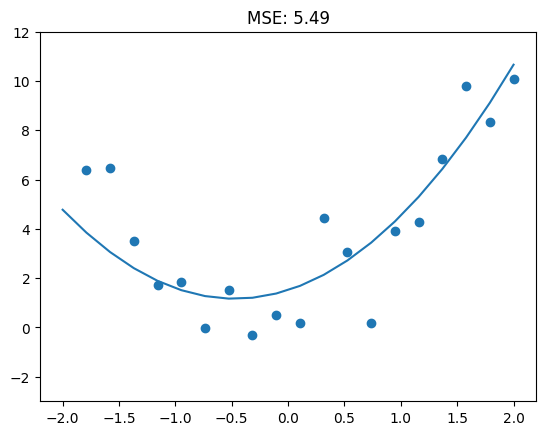

In [17]:
with torch.no_grad():
    abc -= abc.grad * 0.01
    loss = quad_mse(abc)

print(abc)
print(f"loss: {loss:.2f}")
plot_quad(*abc.detach().numpy())

> if we do it in a loop you'll observe our fit becomes better and better

In [18]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()
for i in range(6):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad*0.01
    print(f"step={i+1}; loss={loss:.2f}")
    

step=1; loss=5.83
step=2; loss=5.49
step=3; loss=4.90
step=4; loss=4.23
step=5; loss=3.67
step=6; loss=3.33


> what is the `0.01` number? that's our learning rate

![learning rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_small.svg?raw=1" id="descent_small"/>

# Summary of gradient descent

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective.

# reminder: matrix multiplication
http://matrixmultiplication.xyz

